In [1]:
from urllib.request import urlretrieve
from pyopenms import *
from matplotlib import pyplot as plt

exp = MSExperiment()
MzMLFile().load("20201019_Syam_Spl8.mzML", exp)

protein_ids = []
peptide_ids = []
SimpleSearchEngineAlgorithm().search("20201019_Syam_Spl8.mzML", "uniprot-yourlist_M202201075BF3C56A578D7D6DFD1FC81EE5DA77303B8A7BC.fasta", protein_ids,
                                     peptide_ids)
spectra = exp.getSpectra()


def mirror_plot(obs_mz, obs_int, theo_mz, theo_int, title):
    obs_int = [element / max(obs_int) for element in obs_int]  # relative intenstiy
    theo_int = [element * -1 for element in theo_int]  # invert the intensity for the mirror plot
    plt.figure(figsize=(12, 8))
    plt.bar(obs_mz, obs_int, width=3.0)
    plt.bar(theo_mz, theo_int, width=3.0)
    plt.title(title)
    annot = thspec.getStringDataArrays()[0]
    bars = plt.bar(obs_mz, obs_int, snap=False)  # snap ensures that all bars are rendered
    idx = 0
    for rect in bars:
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width() / 2.0, height, annot[idx].decode(), ha='center', va='bottom',
                 rotation=90)
        idx += 1
    plt.ylim(top=1.2)

    plt.ylabel('intensity')
    plt.xlabel('m/z')
    plt.show()



Peptide ID m/z: 404.204895019531
Peptide ID rt: 1040.43476859102
Peptide scan index: 1191
Peptide scan name: 1191
Peptide ID score type: hyperscore
 - Peptide hit rank: 1
 - Peptide hit charge: 2
 - Peptide hit sequence: VSTQNMK
 - Peptide hit monoisotopic m/z: 404.20509775687094
 - Peptide ppm error: 0.5015704676754449
 - Peptide hit score: 0.052669622004032135
Number of matched peaks: 1
ion	theo. m/z	observed m/z
y6+	1	708.3345047598709	708.0750732421875


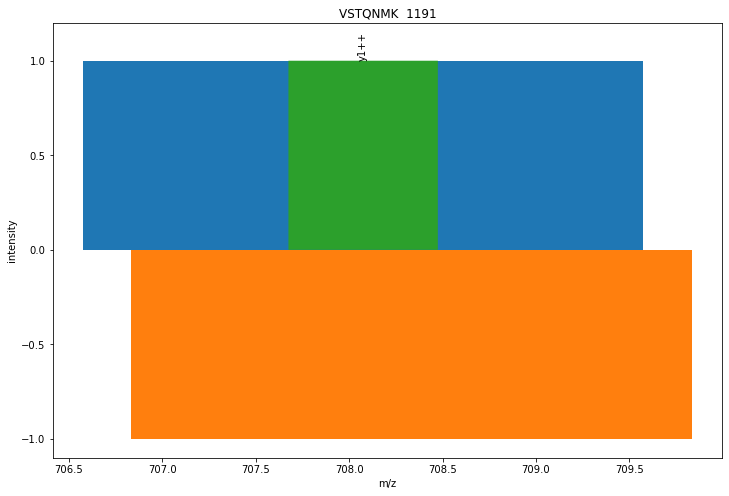

Peptide ID m/z: 536.293273925781
Peptide ID rt: 1234.41334339098
Peptide scan index: 1578
Peptide scan name: 1578
Peptide ID score type: hyperscore
 - Peptide hit rank: 1
 - Peptide hit charge: 2
 - Peptide hit sequence: VVAIYDYTK
 - Peptide hit monoisotopic m/z: 536.289685210871
 - Peptide ppm error: 6.691747033397918
 - Peptide hit score: 0.2191787213087082
Number of matched peaks: 14
ion	theo. m/z	observed m/z
b4+	1	383.265283551371	383.0940793567949
y6++	2	401.702713844021	401.7886352537554
y3+	1	411.223813423771	411.1812334578517
b7++	2	412.713081375921	412.82329697655746
y7++	2	437.221270923771	437.01159867123215
b8++	2	463.23692098757095	463.2492830629939
y8++	2	486.755478067321	487.2484811997973
y4+	1	526.2507575832709	525.7974573631823
b6+	1	661.3555569979709	661.60551674019
y5+	1	689.3140868703708	689.6557397411141
y6+	1	802.3981512212708	802.6924481715047
b7+	1	824.4188862850708	824.559214770902
y7+	1	873.4352653807708	873.4778182102723
y8+	1	972.5036796678709	972.0702063300

ZeroDivisionError: float division by zero

In [7]:
for peptide_id in peptide_ids:
    # Peptide identification values
    print(35 * "=")
    print("Peptide ID m/z:", peptide_id.getMZ())
    print("Peptide ID rt:", peptide_id.getRT())
    print("Peptide scan index:", peptide_id.getMetaValue("scan_index"))
    print("Peptide scan name:", peptide_id.getMetaValue("scan_index"))
    print("Peptide ID score type:", peptide_id.getScoreType())
    # PeptideHits
    for hit in peptide_id.getHits():
        print(" - Peptide hit rank:", hit.getRank())
        print(" - Peptide hit charge:", hit.getCharge())
        print(" - Peptide hit sequence:", hit.getSequence())
        mz = hit.getSequence().getMonoWeight(Residue.ResidueType.Full, hit.getCharge()) / hit.getCharge()
        print(" - Peptide hit monoisotopic m/z:", mz)
        print(" - Peptide ppm error:", abs(mz - peptide_id.getMZ()) / mz * 10 ** 6)
        print(" - Peptide hit score:", hit.getScore())
        tsg = TheoreticalSpectrumGenerator()
        thspec = MSSpectrum()
        p = Param()
        p.setValue("add_y_ions", "true")
        p.setValue("add_b_ions", "true")
        p.setValue("add_metainfo", "true")
        tsg.setParameters(p)
        a = str(hit.getSequence())
        peptide = AASequence.fromString(a)
        tsg.getSpectrum(thspec, peptide, 1, 2)

################################################################################################
        #allignment code
        exp_spec = exp.getSpectrum(peptide_id.getMetaValue("scan_index"))
        alignment = []
        spa = SpectrumAlignment()
        p = spa.getParameters()
        p.setValue("tolerance", 0.5)
        p.setValue("is_relative_tolerance", "false")
        spa.setParameters(p)
        spa.getSpectrumAlignment(alignment, thspec, exp_spec)
        print("Number of matched peaks: " + str(len(alignment)))
        print("ion\ttheo. m/z\tobserved m/z")

        for theo_idx, obs_idx in alignment:
            ion_name = thspec.getStringDataArrays()[0][theo_idx].decode()
            ion_charge = thspec.getIntegerDataArrays()[0][theo_idx]
            print(ion_name + "\t" + str(ion_charge) + "\t" + str(thspec[theo_idx].getMZ()) + "\t" + str(
                exp_spec[obs_idx].getMZ()))

        theo_mz, theo_int, obs_mz, obs_int = [], [], [], []
        b = str(peptide_id.getMetaValue("scan_index"))
        title = a + "  " + b
        for theo_idx, obs_idx in alignment:
            theo_mz.append(thspec[theo_idx].getMZ())
            theo_int.append(thspec[theo_idx].getIntensity())
            obs_mz.append(exp_spec[obs_idx].getMZ())
            obs_int.append(exp_spec[obs_idx].getIntensity())
        if obs_int==0:continue
        mirror_plot(obs_mz, obs_int, theo_mz, theo_int, title)